# Pytroch Classification (Neural Network)

In [1287]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.03, random_state=45)
X.shape, y.shape


((1000, 2), (1000,))

In [1288]:
print("First 5 sample of X : \n", X[:5].shape)
print("First 5 sample of Y : \n", y[:5].shape)

First 5 sample of X : 
 (5, 2)
First 5 sample of Y : 
 (5,)


# Convert into dataframe

In [1289]:
import pandas as pd

circles_df = pd.DataFrame({"X1":X[:,0], "X2":X[:,1], "y":y})
circles_df.head()

,X1,X2,y
0,-0.789039,0.261746,1
1,-0.981376,0.079900,0
2,-0.422771,-0.904301,0
3,0.749791,-0.244409,1
4,0.397403,-0.645001,1


In [1290]:
circles_df.corr()

,X1,X2,y
X1,1.000000,-0.004536,-0.000042
X2,-0.004536,1.000000,-0.001720
y,-0.000042,-0.001720,1.000000


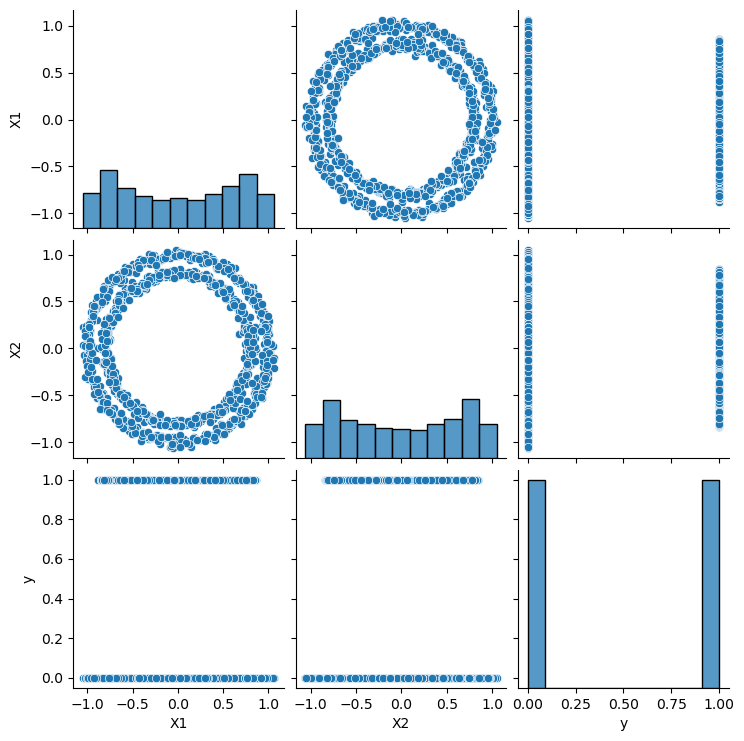

In [1291]:
import seaborn as sns

sns.pairplot(circles_df)

In [1292]:
x1 = circles_df[y == 0]["X1"]
x2 = circles_df[y == 0]["X2"]

x1.shape


(500,)

# Potting the Dataframe

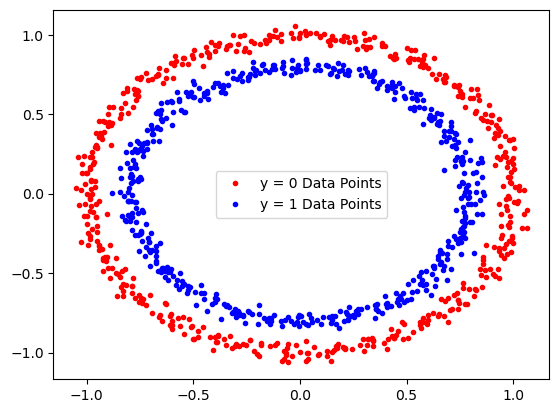

In [1293]:
import matplotlib.pyplot as plt

plt.plot(circles_df[y == 0]["X1"], circles_df[y == 0]["X2"], "r.", label="y = 0 Data Points")
plt.plot(circles_df[y == 1]["X1"], circles_df[y == 1]["X2"], "b.", label="y = 1 Data Points")
plt.legend()
plt.show()

# Changing to Standarad Scaler

In [1294]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# y = y.reshape(-1,1)
# y = scaler.transform(y)
# X.shape, y.shape

# Train Test Split

In [1295]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape
# X_train

((700, 2), (700,))

In [1296]:
# X_train[y_train == 0][:,0]

# Plotting the Train Data

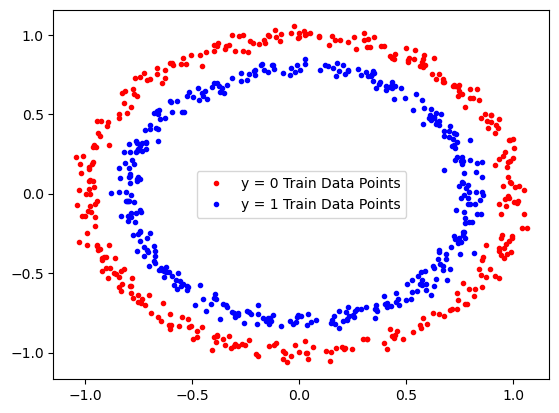

In [1297]:
import matplotlib.pyplot as plt

plt.plot(X_train[y_train == 0][:,0], X_train[y_train == 0][:,1], "r.", label="y = 0 Train Data Points")
plt.plot(X_train[y_train == 1][:,0], X_train[y_train == 1][:,1], "b.", label="y = 1 Train Data Points")
plt.legend()
plt.show()

# Convert the Numpy Array into Tensors

In [1298]:
type(X_train), X_train.shape, y_train.shape

(numpy.ndarray, (700, 2), (700,))

In [1299]:
# y_train = y_train.reshape(-1,1)
type(X_train), X_train.shape, y_train.shape


(numpy.ndarray, (700, 2), (700,))

In [1300]:
import torch

X_train_tensor = torch.from_numpy(X_train).type(torch.float)
y_train_tensor = torch.from_numpy(y_train).type(torch.float)

X_test_tensor = torch.from_numpy(X_test).type(torch.float)
y_test_tensor = torch.from_numpy(y_test).type(torch.float)

X_train_tensor.shape, y_train_tensor.shape

(torch.Size([700, 2]), torch.Size([700]))

a## 0. Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, haeight, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

Of course, this ingredient list of classification neural network components will vary depending on the problem you're working on.

But it's more than enough to get started.

We're going to get hands-on with this setup throughout this notebook.

# Basics About the above problems

`No. of Input Features` = 2 (X1/X2)

`No of Output (Class)` = 2 (0/1)

In [1301]:
X_train_tensor.shape, y_train_tensor.shape
# /64

(torch.Size([700, 2]), torch.Size([700]))

In [1302]:
X_train_tensor[2], y_train_tensor[2]

(tensor([ 0.4663, -0.7026]), tensor(1.))

# Build A Model to classify blue and red dots

* consturct a model by using subclass nn.modules
* Loss function and optimizer
* training and test loop 


In [1303]:
import torch 
from torch import nn

In [1304]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [1305]:
class ClassficationSolverCircle(nn.Module):
    def __init__(self, X):
        super().__init__()
        # create 2 nn.linear layer
        # torch.manual_seed(42)
        no_of_feature = X.shape[1]
        self.layer1 = nn.Linear(in_features=no_of_feature, out_features=4)
        self.layer2 = nn.Linear(in_features=4, out_features=1)

    def forward(self, x):
        x = self.layer1(x)
        return self.layer2(x)


model = ClassficationSolverCircle(X)
print(model)
print(model.state_dict())


ClassficationSolverCircle(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=1, bias=True)
)
OrderedDict({'layer1.weight': tensor([[-0.0258,  0.1321],
        [-0.1878,  0.4820],
        [ 0.0773, -0.6535],
        [-0.0766, -0.3207]]), 'layer1.bias': tensor([ 0.0687, -0.0822, -0.7014, -0.1289]), 'layer2.weight': tensor([[-0.0479, -0.1474,  0.4594, -0.1091]]), 'layer2.bias': tensor([0.3212])})


In [1306]:
model.parameters

<bound method Module.parameters of ClassficationSolverCircle(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=1, bias=True)
)>

# Creating above model using sequential

In [1307]:
model_1 = nn.Sequential(
    nn.Linear(in_features = 2, out_features=4),
    nn.Linear(in_features = 4, out_features=1)
)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=1, bias=True)
)

In [1308]:
# prediction using our model
with torch.inference_mode():
    ypre = model(X_test_tensor)
ypre.shape

torch.Size([300, 1])

# Loss function and optimizer

In [1309]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.1)

# Accuarcy

In [1310]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Raw Logits -> Prediction Probabilities -> Prediction Labels

`Since we are using the BCELossWithLogits`

we can convert these **logits** into **prediction probabilites** by passing them to some kind of **activation function** (e.g. `sigmoid for binary classificaiton and softmax for multiclass classfication`)

then we can convfert ourr models **predicted probabalities** to **prediction labesl** by either **rounding** up or taking the **argmax()**

In [1311]:
y_pred_labels = torch.round(torch.sigmoid(model(X_train_tensor)))
y_pred_labels.shape


torch.Size([700, 1])

# Training and Testing loop

In [1312]:
epochs = 100
# print(X_train_tensor.shape, y_train_tensor.shape)

for i in range(epochs):
    # train
    model.train()
    # forward pass
    y_logits = model(X_train_tensor).squeeze()
    y_pred_labels = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train_tensor) # nn.BCELossWitheLogits expects the logits
    # l = loss_fn(torch.sigmoid(y_logits), y_train_tensor) # nn.BCELoss expects the prediction probabilites
    acc = accuracy_fn(y_true=y_train_tensor, y_pred=y_pred_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ((i+1) % 50) == 0:
        print(f"Epoch [{i+1}/{epochs}] :: Accuracy is ({acc:.2f}) % and Loss is {loss:.2f}")

Epoch [50/100] :: Accuracy is (53.43) % and Loss is 0.69
Epoch [100/100] :: Accuracy is (54.14) % and Loss is 0.69


# Testing

In [1313]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_test_tensor).squeeze()
    y_pred_labels = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_test_tensor)
    acc = accuracy_fn(y_true=y_test_tensor, y_pred=y_pred_labels)

print(f"Accuarcy of Test Dataset :: {acc:.2f} %")

Accuarcy of Test Dataset :: 47.00 %


In [ ]:
# 71